# LSN Exercise 7

In this numerical exercise we are going to study the thermodynamic properties of a classic fluid using **NVT Monte Carlo simulations**. In order to give a realistic estimation of the average values of energy and pressure in various phases, we compute the **autocorrelation function** and we study the trend of statistical uncertainties as a function of the simulation block lenght.

In [1]:
# Settings and libraries:

import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

TITLE_SIZE = 24
LABEL_SIZE = 16
SCALE = 7
FIG_SIZE = (SCALE*0.5*(1+np.sqrt(5)),SCALE)

# Input functions:

def Read(filename):
    with open(filename) as f:
        vector = [float(i) for i in f.read().splitlines()]
    return vector

# ----------------------------------------------------------

def Read_obs(filename):
    
    a = []
    b = []
    c = []
    
    with open(filename) as f:
        data = f.read().splitlines()
    
    for i in range(len(data)):
        data[i] = data[i].split()
        a.append(float(data[i][0]))
        b.append(float(data[i][2]))
        c.append(float(data[i][3]))

    return a, b, c

# --------------------------------------------------

def Read_gofr(filename):
    
    a = []
    b = []
    c = []
    
    with open(filename) as f:
        data = f.read().splitlines()
    
    for i in range(len(data)):
        data[i] = data[i].split()
        a.append(float(data[i][0]))
        b.append(float(data[i][1]))
        c.append(float(data[i][2]))

    return a, b, c

# --------------------------------------------------

## 7.1 Data analysis

Simulations in the NVT ensemble exploit MC sampling techniques to simulate an ensemble of particles at fixed temperature $T$ and number of particles $N$. Our C++ code implements the *Metropolis-Hastings algorithm* to sample from configurations of the ensemble according to the *Boltzmann distribution*, which contains the exact form of the interparticle interaction potential. In order to properly *estimate errors* for the *internal energy* and *pressure*, we adopt the *data-blocking-technique*: the istantaneous values computed every MC step are grouped in *blocks, whose length must be enough to guarantee that the CLT holds*.

To prepare the simulation we follow these steps:

- 1) Choose an fcc initial configuration (`cp config.fcc config.0`)and set the proper values of temperature, density and cut-off radius in the "input.dat" file, depending on the phase to simulate;
- 2) Run an equilibration simulation, priting the istantaneous values of energy and pressure;
- 3) Plot the istantaneous values to give an estimation for the equilibration steps;
- 4) Starting from the equilibrated configuration (`cp config.final config.0`), using a large number of MC steps collect a huge data-set;
- 5) Analyze the data-set estimating the *autocorrelation function* for both pressure and energy: extrapolation of the *correlation time scale* in MC steps units gives a lower-bound for the blocks length;
- 6) Study the errors trend as a fucntion of the block length, looking for the saturation limit in which the errors stop growing monotonously and start oscillating.

The following code contains two functions written for data the analysis described in the previous points. The `AC_function` uses the `np.corrcoef(X,Y)[0,1]` function to compute the correlation coefficient between the set X and Y, here the same copy of a series shifted for different time steps.

In [5]:
# Data analysis functions: 

def AC_function(series, d_range):
    
    """Autocorrelation function 
    for a time series
    
    Input: 
    >>> 'series': is a type list or
    np.array containing the time series
    
    >>> 'd_range': is a type int choosing
    the range of the delay
    
    -----------------------------------
    Output: 
    >>> 'AC': is a type list containing
    autocorrelation coefficients, evaluated
    for time delayed copies of the process
    
    """
    AC = []
    for steps in range(1,d_range):
        corr = np.corrcoef(series[:-steps], series[steps:])[0,1]
        AC.append(corr)
    return AC

# ------------------------------------------------------------------

def MC_Error(Input, length):
        
    """ Estimation of errors as a
    function of blocks length in MC 
    Data Blocking method 
    
    Input: 
    >>> 'Input': is a type list or
    np.array containing datas
    
    >>> 'length': is a type int that fixes
    the length of the block
    
    -----------------------------------
    Output:     
    >>> 'Error_final': is a type float: the error
    of the averages of each block
    
    """
    n_data = int(len(Input))
    n_blocks = int(n_data/length)

    average = []
    average2 = []
    average_f = 0
    average2_f = 0
    error = 0
    
    for i in range(n_blocks):
        average.append(0)
        average2.append(0)

    for i in range(n_blocks):
        for j in range(length):
            pos = (i*length) + j 
            average[i] += Input[pos]
        average[i] /= length
        average2[i] = average[i]**2
        
    for i in range(n_blocks):
        average_f += average[i]
        average2_f += average2[i]
    
    average_f /= n_blocks
    average2_f /= n_blocks
        
    error = np.sqrt((average2_f - average_f**2)/(n_blocks - 1))
        
    return error

# -------------------------------------------------------------------

## 7.1.1 Solid phase

For the **solid phase** we set $\rho^\star = 1.1$, $T^\star = 0.8$ and cut-off radius $r_c = 2.2$. We run a first simulation to equilibrate the sample, using $1000$ MC steps.

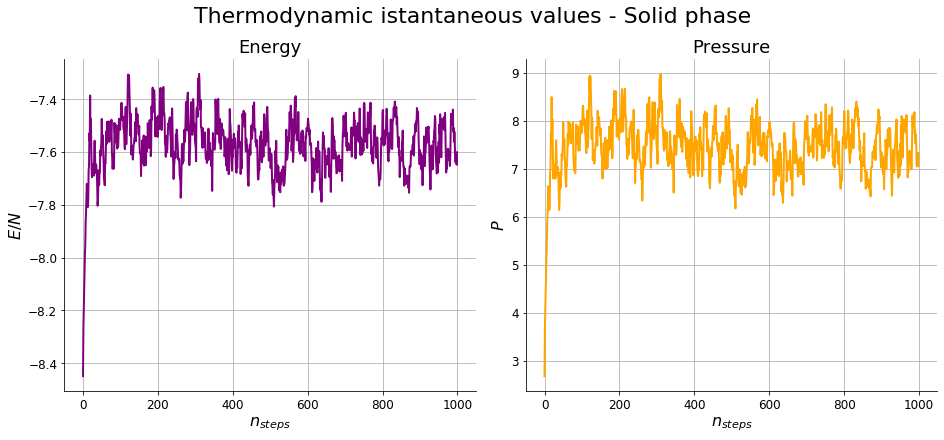

In [3]:
Energy_S = Read("equi/Energy_S.ist")
Pressure_S = Read("equi/Pressure_S.ist")
N = np.arange(len(Energy_S))

fig, (E,P) = plt.subplots(1,2, figsize=(13,6), constrained_layout=True)
fig.suptitle("Thermodynamic istantaneous values - Solid phase", fontsize=22)

E.plot(N, Energy_S, color='purple')
E.set_title("Energy")
E.set_xlabel("$ n_{steps} $")
E.set_ylabel("$ E/N $")
E.grid()

P.plot(N, Pressure_S, color='orange')
P.set_title("Pressure")
P.set_xlabel("$ n_{steps} $")
P.set_ylabel("$ P $")
P.grid()

From the previous plots we see that the sample immeadiately equilibrates; the reason of this lies in the fact we have started the simulation from a fcc crystalline configuration. Using $n_{eq}=1000$ steps we generate an equilibrated configuration, the starting point for the simulation during which we collect istantaneous values for a total of $10^5$ MC steps. Using the `AC_function` we plot the autocorrelation function in order to have an idea of the proper lengths of the blocks.

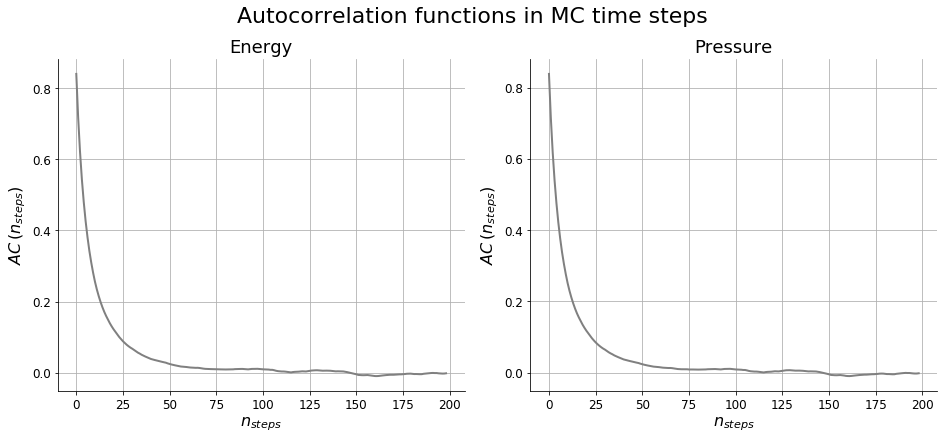

In [5]:
Energy_S = Read("block_extim/Energy_S.ist")
Pressure_S = Read("block_extim/Pressure_S.ist")

AC_energy = AC_function(Energy_S, 200)
AC_pressure = AC_function(Pressure_S, 200)
T = np.arange(len(AC_energy))

fig, (E,P) = plt.subplots(1,2, figsize=(13,6), constrained_layout=True)
fig.suptitle("Autocorrelation functions in MC time steps", fontsize=22)

E.plot(T, AC_energy, color='grey')
E.set_title("Energy")
E.set_xlabel("$ n_{steps} $")
E.set_ylabel("$ AC \, (n_{steps}) $")
E.grid()

P.plot(T, AC_pressure, color='grey')
P.set_title("Pressure")
P.set_xlabel("$ n_{steps} $")
P.set_ylabel("$ AC \, (n_{steps}) $")
P.grid()

The correlaction functions for the energy and pressure are similar, and this can be explained by the fact that the latter is linked to the former by the *virial equation*:

$$ P = \rho K_B T + \frac{\langle W \rangle}{V} $$

The decay is exponential, and after $50$ MC steps the correlation drops to a negligible value: every time interval of this order divides configurations uncorrelated from each other. Blocks' length should be at least a multiple of $50$; studying the dependence of the error from the blocks' length we can choose a reasonable size for the blocks, ensuring that the CLT holds and our statistical uncertainties estimation is valid.

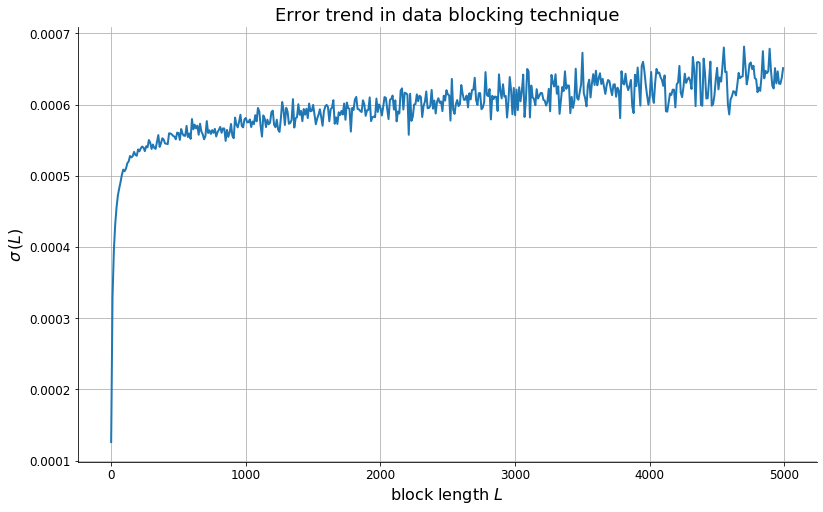

In [6]:
err_trend = []

N = [i for i in range(1,5000,10)]

Energy_S = Read("block_extim/Energy_S.ist")

E_ist = Energy_S[::100]
T = [100*i for i in range(len(E_ist))]

for i in N:
    error = MC_Error(Energy_S, i)
    err_trend.append(error)
    
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(N, err_trend)
plt.title("Error trend in data blocking technique")
plt.xlabel("block length $L$")
plt.ylabel("$ \sigma \, (L) $")
plt.grid()

The error grows monotonously till the approximate length value of $500$; after this limit the error start oscillating, a signal that the true stastical error due to uncorrelated averages in each block has been reached. 

## 7.1.2 Liquid phase

Following the same route for the liquid phase we set: $\rho^\star = 0.8$, $T^\star = 1.1$ and cut-off radius $r_c = 2.5$.

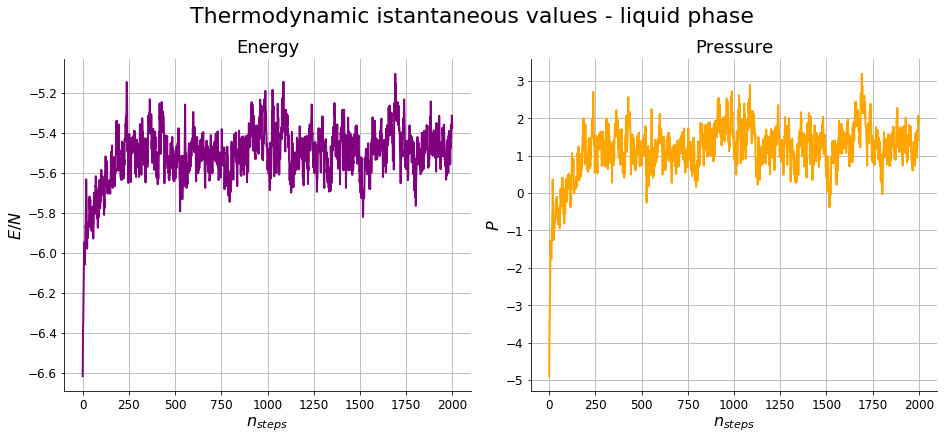

In [52]:
Energy_L = Read("equi/Energy_L.ist")
Pressure_L = Read("equi/Pressure_L.ist")
N = np.arange(len(Energy_L)) 

fig, (E,P) = plt.subplots(1,2, figsize=(13,6), constrained_layout=True)
fig.suptitle("Thermodynamic istantaneous values - liquid phase", fontsize=22)

E.plot(N, Energy_L, color='purple')
E.set_title("Energy")
E.set_xlabel("$ n_{steps} $")
E.set_ylabel("$ E/N $")
E.grid()

P.plot(N, Pressure_L, color='orange')
P.set_title("Pressure")
P.set_xlabel("$ n_{steps} $")
P.set_ylabel("$ P $")
P.grid()

The istantaneous values indicate that $n_{eq}=2000$ is sufficient to equilibrate the sample. We estimate now the proper blocks' length by means of the correlation function and the blocking for different sizes. 

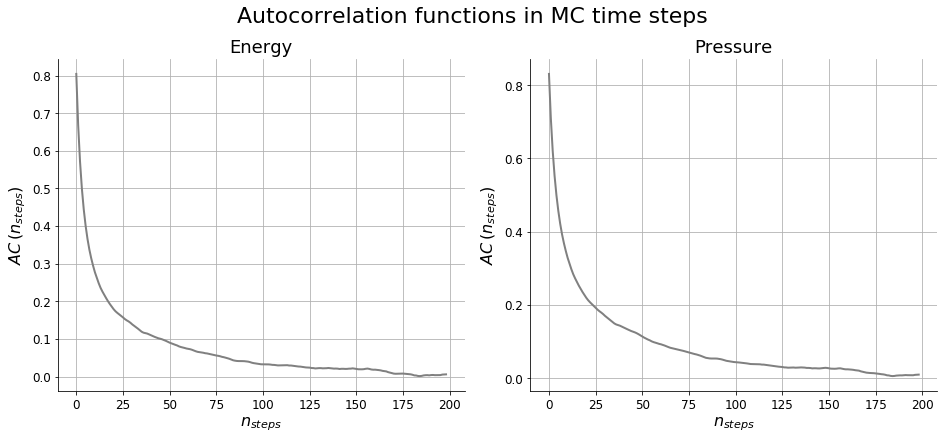

In [54]:
Energy_L = Read("block_extim/Energy_L.ist")
Pressure_L = Read("block_extim/Pressure_L.ist")

AC_energy = AC_function(Energy_L, 200)
AC_pressure = AC_function(Pressure_L, 200)
T = np.arange(len(AC_energy))

fig, (E,P) = plt.subplots(1,2, figsize=(13,6), constrained_layout=True)
fig.suptitle("Autocorrelation functions in MC time steps", fontsize=22)

E.plot(T, AC_energy, color='grey')
E.set_title("Energy")
E.set_xlabel("$ n_{steps} $")
E.set_ylabel("$ AC \, (n_{steps}) $")
E.grid()

P.plot(T, AC_pressure, color='grey')
P.set_title("Pressure")
P.set_xlabel("$ n_{steps} $")
P.set_ylabel("$ AC \, (n_{steps}) $")
P.grid()

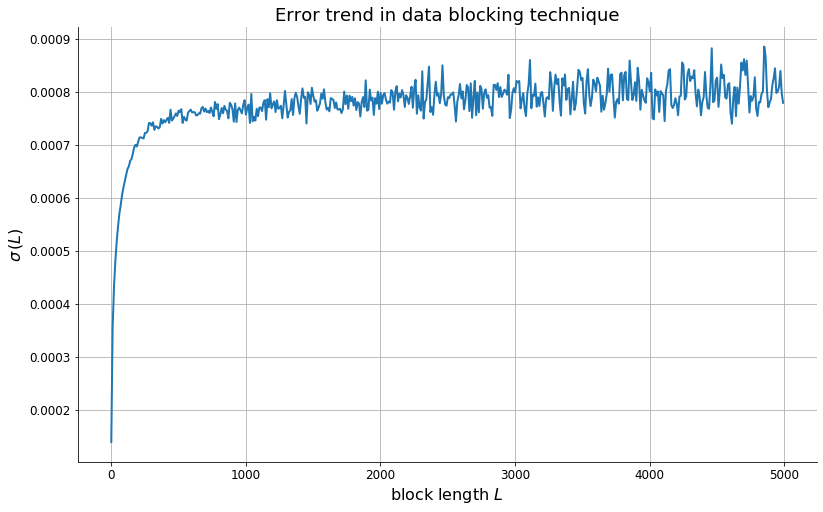

In [13]:
err_trend = []

N = [i for i in range(1,5000,10)]

Energy_L = Read("block_extim/Energy_L.ist")

E_ist = Energy_L[::100]
T = [100*i for i in range(len(E_ist))]

for i in N:
    error = MC_Error(Energy_L, i)
    err_trend.append(error)
    
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(N, err_trend)
plt.title("Error trend in data blocking technique")
plt.xlabel("block length $L$")
plt.ylabel("$ \sigma \, (L) $")
plt.grid()

We can safely choose $L=500$ as in the solid phase of Argon. 

## 7.1.3 Gas phase

Finally, the gas phase is characterized by: $\rho^\star = 0.05$, $T^\star = 1.2$ and cut-off radius $r_c = 5.0$. The equilibration time is longer if we start from an fcc configuration: we take $n_{eq}=20000$ just to be sure.

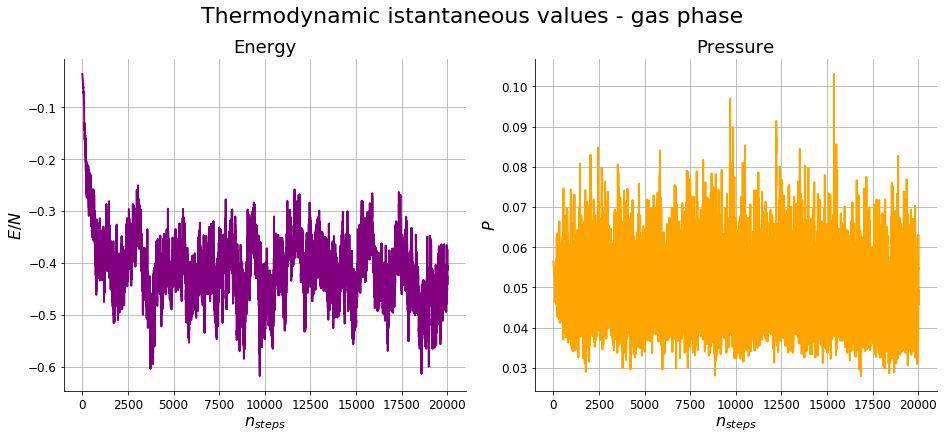

In [9]:
Energy_G = Read("equi/Energy_G.ist")
Pressure_G = Read("equi/Pressure_G.ist")
N = np.arange(len(Energy_G))

fig, (E,P) = plt.subplots(1,2, figsize=(13,6), constrained_layout=True)
fig.suptitle("Thermodynamic istantaneous values - gas phase", fontsize=22)

E.plot(N, Energy_G, color='purple')
E.set_title("Energy")
E.set_xlabel("$ n_{steps} $")
E.set_ylabel("$ E/N $")
E.grid()

P.plot(N, Pressure_G, color='orange')
P.set_title("Pressure")
P.set_xlabel("$ n_{steps} $")
P.set_ylabel("$ P $")
P.grid()

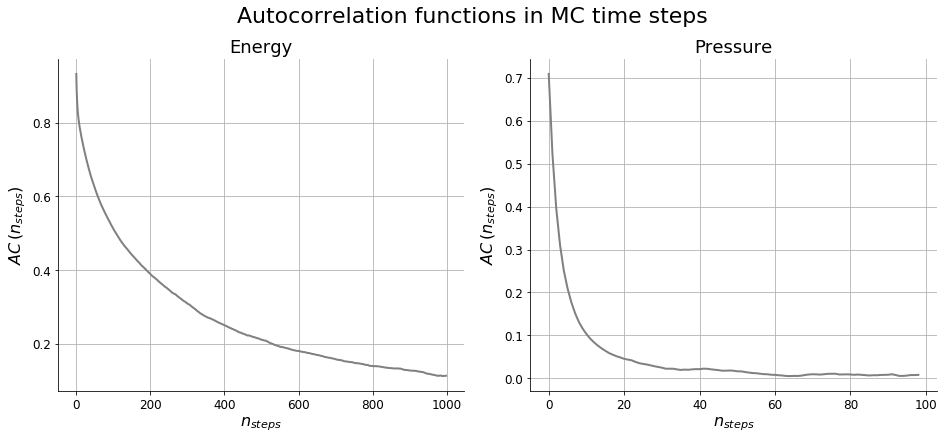

In [70]:
Energy_G = Read("block_extim/Energy_G.ist")
Pressure_G = Read("block_extim/Pressure_G.ist")

AC_energy = AC_function(Energy_G, 1000)
AC_pressure = AC_function(Pressure_G, 100)
T1 = np.arange(len(AC_energy))
T2 = np.arange(len(AC_pressure))

fig, (E,P) = plt.subplots(1,2, figsize=(13,6), constrained_layout=True)
fig.suptitle("Autocorrelation functions in MC time steps", fontsize=22)

E.plot(T1, AC_energy, color='grey')
E.set_title("Energy")
E.set_xlabel("$ n_{steps} $")
E.set_ylabel("$ AC \, (n_{steps}) $")
E.grid()

P.plot(T2, AC_pressure, color='grey')
P.set_title("Pressure")
P.set_xlabel("$ n_{steps} $")
P.set_ylabel("$ AC \, (n_{steps}) $")
P.grid()

The correlation functions for the energy and pressure shows a different correlation time scale: to estimate the proper block size we rely on the study of error trends in the data blocking method, as follows here.

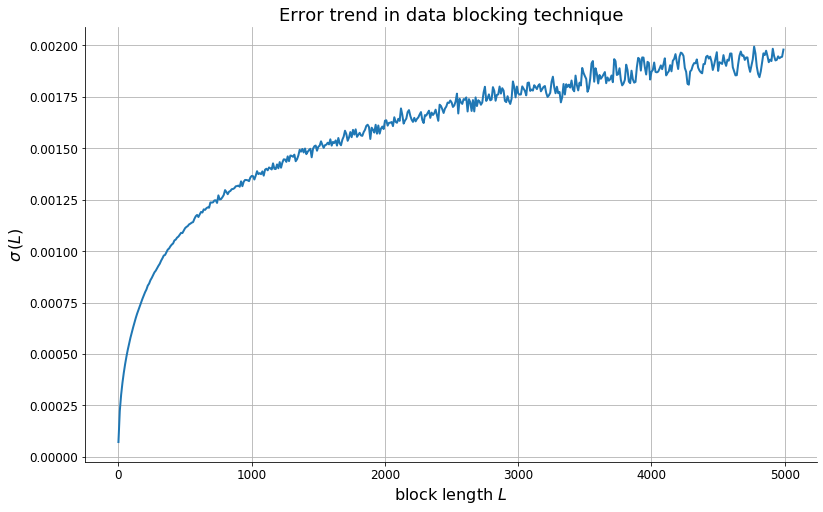

In [14]:
err_trend = []

N = [i for i in range(1,5000,10)]

Energy_G = Read("block_extim/Energy_G.ist")

E_ist = Energy_G[::100]
T = [100*i for i in range(len(E_ist))]

for i in N:
    error = MC_Error(Energy_G, i)
    err_trend.append(error)
    
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(N, err_trend)
plt.title("Error trend in data blocking technique")
plt.xlabel("block length $L$")
plt.ylabel("$ \sigma \, (L) $")
plt.grid()

To properly simulate the gas phase we must use larger blocks: the error start saturating after $L \sim 4000$.

## 7.2 Averages and distribution functions

The study of the proper equilibration time and blocks' size allow us to estimate average properties and uncertainties using data blocking. For every phase of the Argon ($\epsilon/k_B = 120 K$ and $\sigma = 0.34$ nm) we estimate the *average energy per particle* and *pressure*, dividing the simulation in $100$ blocks.

Another important parameter is the *size of Metropolis moves*: new spatial configurations are sampled from a uniform distribution centered on the the old configurations. To ensure enough efficiency and uncorrelation, we fix this parameter in order to obtain a $50%$ acceptance rate.

**Solid phase:** $n_{eq}=1000$, block size $L=500$, step size $t=0.12$.

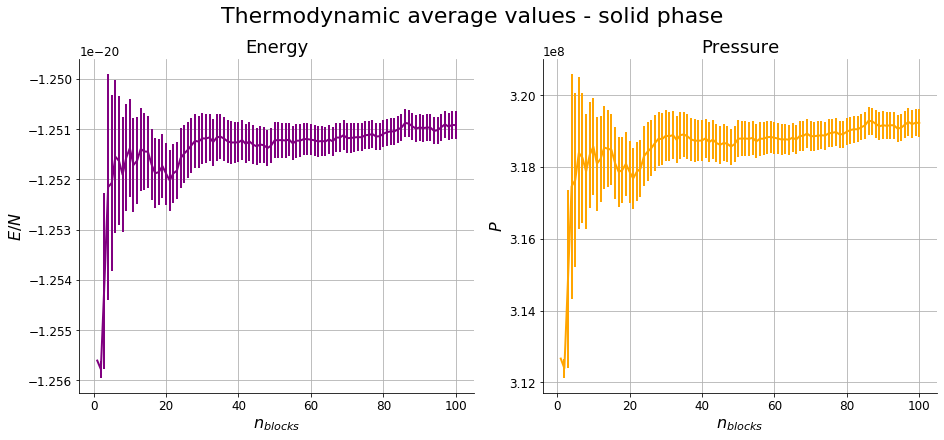

In [14]:
# SI scaling factors:

Kb = constants.Boltzmann
eps = 120*Kb
sigma = 0.34*10**(-9)
p_scale = eps/(sigma**3)

# --------------------------

en_blocks, en, en_err = Read_obs("Solid/output.epot.0")
en = [eps*i for i in en]
en_err = [eps*i for i in en_err]
pres_blocks, pres, pres_err = Read_obs("Solid/output.pres.0")
pres = [p_scale*i for i in pres]
pres_err = [p_scale*i for i in pres_err]

fig, (E,P) = plt.subplots(1,2, figsize=(13,6), constrained_layout=True)
fig.suptitle("Thermodynamic average values - solid phase", fontsize=22)

E.errorbar(en_blocks, en, yerr=en_err, color='purple')
E.set_title("Energy")
E.set_xlabel("$ n_{blocks} $")
E.set_ylabel("$ E/N $")
E.grid()

P.errorbar(pres_blocks, pres, yerr=pres_err, color='orange')
P.set_title("Pressure")
P.set_xlabel("$ n_{blocks} $")
P.set_ylabel("$ P $")
P.grid()

**Liquid phase:** $n_{eq}=2000$, block size $L=500$, step size $t=0.2$.

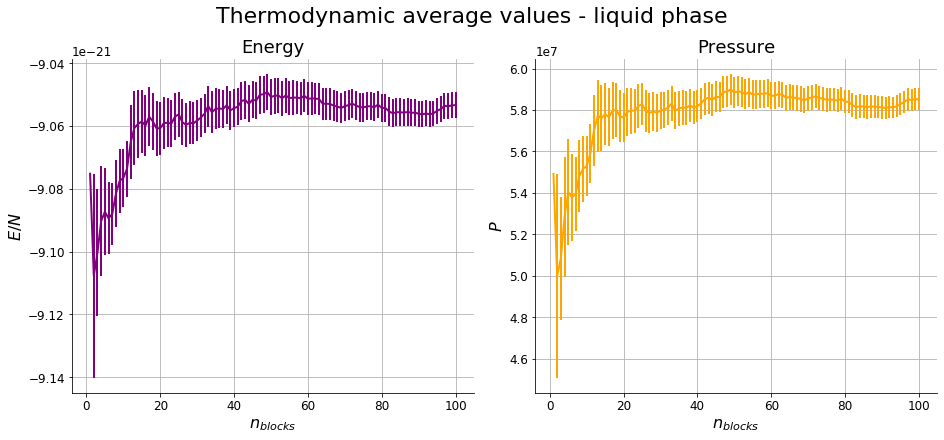

In [16]:
en_blocks, en, en_err = Read_obs("Liquid/output.epot.0")
en = [eps*i for i in en]
en_err = [eps*i for i in en_err]
pres_blocks, pres, pres_err = Read_obs("Liquid/output.pres.0")
pres = [p_scale*i for i in pres]
pres_err = [p_scale*i for i in pres_err]

fig, (E,P) = plt.subplots(1,2, figsize=(13,6), constrained_layout=True)
fig.suptitle("Thermodynamic average values - liquid phase", fontsize=22)

E.errorbar(en_blocks, en, yerr=en_err, color='purple')
E.set_title("Energy")
E.set_xlabel("$ n_{blocks} $")
E.set_ylabel("$ E/N $")
E.grid()

P.errorbar(pres_blocks, pres, yerr=pres_err, color='orange')
P.set_title("Pressure")
P.set_xlabel("$ n_{blocks} $")
P.set_ylabel("$ P $")
P.grid()

**Gas phase:** $n_{eq}=20000$, block size $L=4000$, step size $t=6.0$ (acceptance $\sim 60\%$).

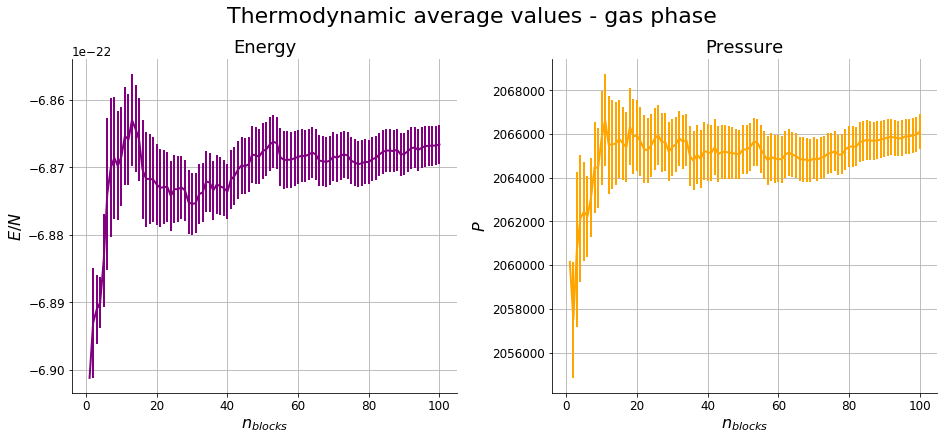

In [17]:
en_blocks, en, en_err = Read_obs("Gas/output.epot.0")
en = [eps*i for i in en]
en_err = [eps*i for i in en_err]
pres_blocks, pres, pres_err = Read_obs("Gas/output.pres.0")
pres = [p_scale*i for i in pres]
pres_err = [p_scale*i for i in pres_err]

fig, (E,P) = plt.subplots(1,2, figsize=(13,6), constrained_layout=True)
fig.suptitle("Thermodynamic average values - gas phase", fontsize=22)

E.errorbar(en_blocks, en, yerr=en_err, color='purple')
E.set_title("Energy")
E.set_xlabel("$ n_{blocks} $")
E.set_ylabel("$ E/N $")
E.grid()

P.errorbar(pres_blocks, pres, yerr=pres_err, color='orange')
P.set_title("Pressure")
P.set_xlabel("$ n_{blocks} $")
P.set_ylabel("$ P $")
P.grid()

Another quantity of interest in the study of the static properties of a system of interacting particles is the **radial distribution function** $g(r)$: $g(r)dr$ gives the probability of finding any two particles in a spherical shell of thickness $dr$. To estimate $g(r)$ we fill an histogram of $n=100$ bins and bin-size given by $\frac{0.5L}{n}$, with $L$ the size of he simulation box; cycling over pairs of particles we increase the bin counting by $2$ every time we find two particles at a specific distance. We save the outputs for each simulation block in a file called `output.gofr.0` and, at the end of the simulation, we compute averages and errors as a function of the number of blocks for each bin of the histogram, saving the final results in `output.gave.0`. This last step is accompanied with the *normalization of the histogram*: the average number of particles for every distance $r$ is divivded by a factor $\rho N \Delta V(r) = N^2 \frac{\Delta V(r)}{V}$, with $\Delta V(r)$ the spherical shell volume between $r$ and $r+dr$.

Implementing the same routine for the **NVE-molecular-dynamics code**, we can compare the distribution functions for each of the three phases, as shown in what follows (files `output.gave.0` and `output_gofr.ave`).

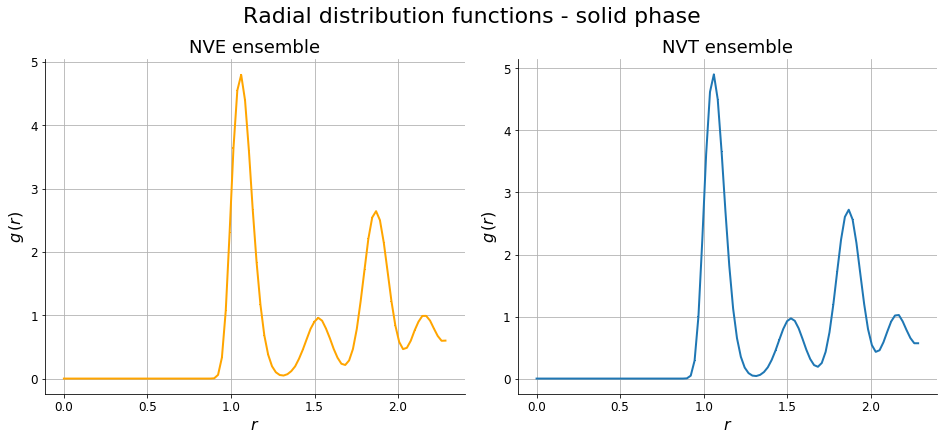

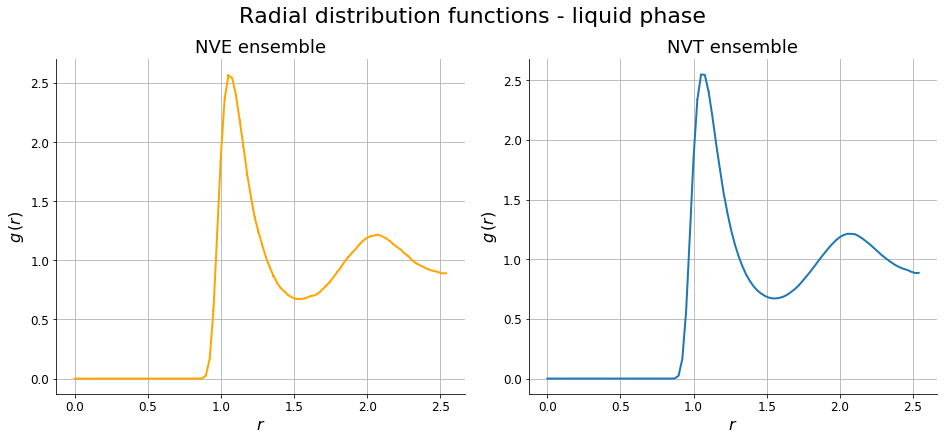

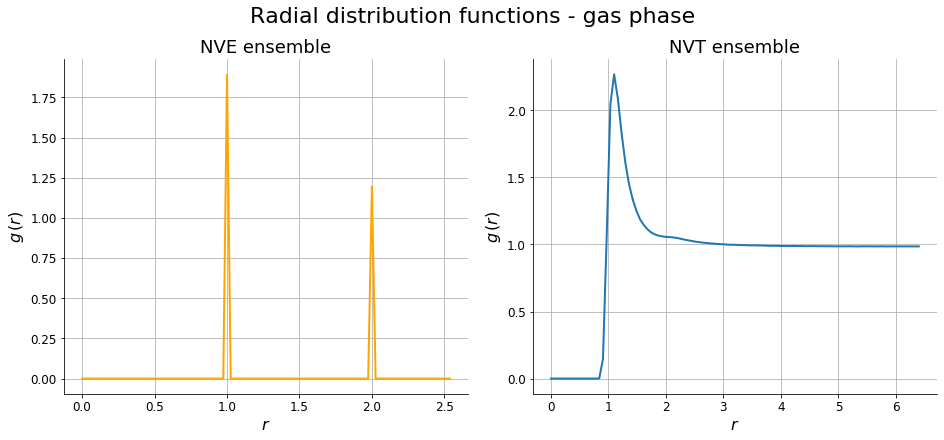

In [12]:
# Solid phase

r1, g_r1, err1 = Read_gofr("Solid/output_gofr.ave")
r2, g_r2, err2 = Read_gofr("Solid/output.gave.0")

fig, (sol_NVE, sol_NVT) = plt.subplots(1,2, figsize=(13,6), constrained_layout=True)
fig.suptitle("Radial distribution functions - solid phase", fontsize=22)

sol_NVE.errorbar(r1, g_r1, yerr=err1, color='orange')
sol_NVE.set_title("NVE ensemble")
sol_NVE.set_xlabel("$r$")
sol_NVE.set_ylabel("$g \, (r)$")
sol_NVE.grid()

sol_NVT.errorbar(r2, g_r2, yerr=err2)
sol_NVT.set_title("NVT ensemble")
sol_NVT.set_xlabel("$r$")
sol_NVT.set_ylabel("$g \, (r)$")
sol_NVT.grid()

# ------------------------------------------------

# Liquid phase

r1, g_r1, err1 = Read_gofr("Liquid/output_gofr.ave")
r2, g_r2, err2 = Read_gofr("Liquid/output.gave.0")

fig, (sol_NVE, sol_NVT) = plt.subplots(1,2, figsize=(13,6), constrained_layout=True)
fig.suptitle("Radial distribution functions - liquid phase", fontsize=22)

sol_NVE.errorbar(r1, g_r1, yerr=err1, color='orange')
sol_NVE.set_title("NVE ensemble")
sol_NVE.set_xlabel("$r$")
sol_NVE.set_ylabel("$g \, (r)$")
sol_NVE.grid()

sol_NVT.errorbar(r2, g_r2, yerr=err2)
sol_NVT.set_title("NVT ensemble")
sol_NVT.set_xlabel("$r$")
sol_NVT.set_ylabel("$g \, (r)$")
sol_NVT.grid()

# ------------------------------------------------

# Gas phase

r1, g_r1, err1 = Read_gofr("Gas/output_gofr.ave")
r2, g_r2, err2 = Read_gofr("Gas/output.gave.0")

fig, (sol_NVE, sol_NVT) = plt.subplots(1,2, figsize=(13,6), constrained_layout=True)
fig.suptitle("Radial distribution functions - gas phase", fontsize=22)

sol_NVE.errorbar(r1, g_r1, yerr=err1, color='orange')
sol_NVE.set_title("NVE ensemble")
sol_NVE.set_xlabel("$r$")
sol_NVE.set_ylabel("$g \, (r)$")
sol_NVE.grid()

sol_NVT.errorbar(r2, g_r2, yerr=err2)
sol_NVT.set_title("NVT ensemble")
sol_NVT.set_xlabel("$r$")
sol_NVT.set_ylabel("$g \, (r)$")
sol_NVT.grid()